In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation

# import plotly.express as px
# import plotly.io as pio
# pio.renderers.default = 

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.set_option('display.float_format', lambda x : '%.2f' % x)
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# 데이터 로드
PatientInfo = pd.read_csv('/content/PatientInfo.csv')
Region = pd.read_csv('/content/Region.csv')

In [ ]:
print('the number of unique values in city:', len(Region.city.unique()))
Region['city'].unique()

the number of unique values in city: 222


array(['Seoul', 'Gangnam-gu', 'Gangdong-gu', 'Gangbuk-gu', 'Gangseo-gu',
       'Gwanak-gu', 'Gwangjin-gu', 'Guro-gu', 'Geumcheon-gu', 'Nowon-gu',
       'Dobong-gu', 'Dongdaemun-gu', 'Dongjak-gu', 'Mapo-gu',
       'Seodaemun-gu', 'Seocho-gu', 'Seongdong-gu', 'Seongbuk-gu',
       'Songpa-gu', 'Yangcheon-gu', 'Yeongdeungpo-gu', 'Yongsan-gu',
       'Eunpyeong-gu', 'Jongno-gu', 'Jung-gu', 'Jungnang-gu', 'Busan',
       'Geumjeong-gu', 'Gijang-gun', 'Nam-gu', 'Dong-gu', 'Dongnae-gu',
       'Busanjin-gu', 'Buk-gu', 'Sasang-gu', 'Saha-gu', 'Seo-gu',
       'Suyeong-gu', 'Yeonje-gu', 'Yeongdo-gu', 'Haeundae-gu', 'Daegu',
       'Dalseo-gu', 'Dalseong-gun', 'Suseong-gu', 'Gwangju',
       'Gwangsan-gu', 'Incheon', 'Ganghwa-gun', 'Gyeyang-gu',
       'Michuhol-gu', 'Namdong-gu', 'Bupyeong-gu', 'Yeonsu-gu',
       'Ongjin-gun', 'Daejeon', 'Daedeok-gu', 'Yuseong-gu', 'Ulsan',
       'Ulju-gun', 'Sejong', 'Gyeonggi-do', 'Gapyeong-gun', 'Goyang-si',
       'Gwacheon-si', 'Gwangmyeong-si', 'Gwan

### 도시 별 진료소 개수

In [ ]:
region = Region[['city', 'nursing_home_count', 'population']]
region

,city,nursing_home_count,population
0,Seoul,22739,NaN
1,Gangnam-gu,3088,NaN
2,Gangdong-gu,1023,NaN
3,Gangbuk-gu,628,NaN
4,Gangseo-gu,1080,NaN
...,...,...,...
239,Haman-gun,94,NaN
240,Hamyang-gun,83,NaN
241,Hapcheon-gun,96,NaN
242,Jeju-do,1245,NaN


### 도시별 사망자 생존자 그룹 분류

In [ ]:
state = PatientInfo[['city', 'state']]
state

,city,state
0,Gangseo-gu,released
1,Jungnang-gu,released
2,Jongno-gu,released
3,Mapo-gu,released
4,Seongbuk-gu,released
...,...,...
3999,Jeju-do,released
4000,Jeju-do,isolated
4001,Jeju-do,released
4002,Jeju-do,released


회복해서 방출된 released 와 자가격리자(isolated)를 alive로, 사망자를 deceased로 분류

In [ ]:
alive = ['released', 'isolated']
deceased = ['deceased']

def statement(x):
  group = None
  if x in deceased:
    group = 'deceased'
  else:
    group = 'alive'
  return group

PatientInfo['state_group'] = PatientInfo['state'].apply(lambda x: statement(x)) 
group_state = PatientInfo[['city', 'state_group']]
group_state.tail()

,city,state_group
3999,Jeju-do,alive
4000,Jeju-do,alive
4001,Jeju-do,alive
4002,Jeju-do,alive
4003,Jeju-do,alive


생존자 행과 city가 etc에 해당하는 행 제거

In [ ]:
idx_alive = group_state[group_state['state_group'] == 'alive'].index
group_state = group_state.drop(idx_alive)
group_state

,city,state_group
12,Jongno-gu,deceased
284,Mapo-gu,deceased
933,Busanjin-gu,deceased
959,Busanjin-gu,deceased
1012,Nam-gu,deceased
...,...,...
3760,Cheongdo-gun,deceased
3761,Cheongdo-gun,deceased
3762,Cheongdo-gun,deceased
3763,Cheongdo-gun,deceased


In [ ]:
idx_etc = group_state[group_state['city'] == 'etc'].index
group_state = group_state.drop(idx_etc)
group_state

,city,state_group
12,Jongno-gu,deceased
284,Mapo-gu,deceased
933,Busanjin-gu,deceased
959,Busanjin-gu,deceased
1012,Nam-gu,deceased
...,...,...
3760,Cheongdo-gun,deceased
3761,Cheongdo-gun,deceased
3762,Cheongdo-gun,deceased
3763,Cheongdo-gun,deceased


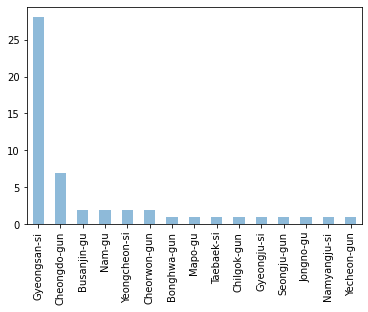

In [ ]:
# city_counts = group_state.city.value_counts()
city_counts = city_counts.sort_values(ascending=False)
city_counts.plot.bar(alpha = 0.5)
plt.show()

### 선별진료소 밀집도

In [ ]:
df_joined = group_state.merge(region, left_on = 'city', right_on = 'city' , how='inner')
df_joined = df_joined.groupby(['city'])['state_group'].count()
df_joined = pd.DataFrame(df_joined)

df_joined = df_joined.rename(columns = {'state_group' : 'deceased_number'})
df_joined.reset_index(inplace = True)
df_joined = df_joined[['city', 'deceased_number']]

df_joined = df_joined.merge(region, left_on = 'city', right_on = 'city' , how='inner')
df_joined = df_joined.dropna()
df_joined

,city,deceased_number,nursing_home_count,population
0,Bonghwa-gun,1,47,"32,150"
1,Busanjin-gu,2,986,"357,880"
2,Cheongdo-gun,7,85,"42,910"
3,Cheorwon-gun,2,70,"45,584"
4,Chilgok-gun,1,151,"117,047"
5,Gyeongju-si,1,407,"255,402"
6,Gyeongsan-si,28,427,"263,185"
7,Jongno-gu,1,668,"151,290"
8,Mapo-gu,1,929,"374,035"
10,Nam-gu,8,345,"274,480"


In [ ]:
df_joined['population'] = df_joined['population'].str.replace(',','')
df_joined['population'] = df_joined['population'].apply(pd.to_numeric)
df_joined
# pop = df_joined.reset_index(drop = 'index')
# pop


,city,deceased_number,nursing_home_count,population
0,Bonghwa-gun,1,47,32150
1,Busanjin-gu,2,986,357880
2,Cheongdo-gun,7,85,42910
3,Cheorwon-gun,2,70,45584
4,Chilgok-gun,1,151,117047
5,Gyeongju-si,1,407,255402
6,Gyeongsan-si,28,427,263185
7,Jongno-gu,1,668,151290
8,Mapo-gu,1,929,374035
10,Nam-gu,8,345,274480


In [ ]:
df_joined['density'] = df_joined['nursing_home_count'] / df_joined['population'] * 10000
df_joined

,city,deceased_number,nursing_home_count,population,density
0,Bonghwa-gun,1,47,32150,14.62
1,Busanjin-gu,2,986,357880,27.55
2,Cheongdo-gun,7,85,42910,19.81
3,Cheorwon-gun,2,70,45584,15.36
4,Chilgok-gun,1,151,117047,12.90
5,Gyeongju-si,1,407,255402,15.94
6,Gyeongsan-si,28,427,263185,16.22
7,Jongno-gu,1,668,151290,44.15
8,Mapo-gu,1,929,374035,24.84
10,Nam-gu,8,345,274480,12.57


In [ ]:
clinic_density_deceased = df_joined[['city', 'deceased_number', 'density']]
clinic_density_deceased

,city,deceased_number,density
6,Gyeongsan-si,28,16.22
10,Nam-gu,8,12.57
2,Cheongdo-gun,7,19.81
1,Busanjin-gu,2,27.55
3,Cheorwon-gun,2,15.36
17,Yeongcheon-si,2,18.74
0,Bonghwa-gun,1,14.62
4,Chilgok-gun,1,12.90
5,Gyeongju-si,1,15.94
7,Jongno-gu,1,44.15


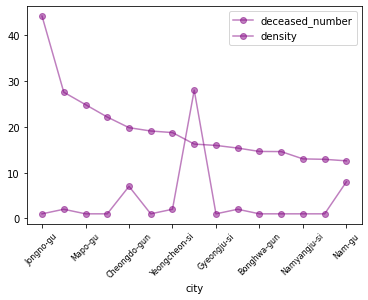

In [ ]:
clinic_density_deceased = clinic_density_deceased.sort_values(by = 'density',ascending=False)
# clinic_density_deceased.plot.bar(alpha = 0.5)
clinic_density_deceased.plot(x = 'city',color='purple', marker='o', linestyle='solid', alpha=0.5)
plt.xticks(fontsize=8,rotation=45)
plt.show()

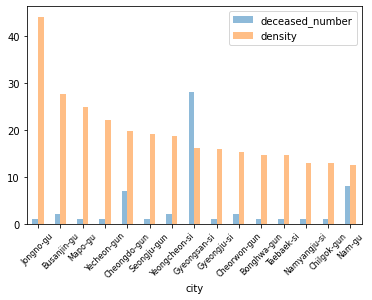

In [ ]:
clinic_density_deceased = clinic_density_deceased.sort_values(by = 'density',ascending=False)
# clinic_density_deceased.plot.bar(alpha = 0.5)
clinic_density_deceased.plot.bar(x = 'city', alpha=0.5)
plt.xticks(fontsize=8,rotation=45)
plt.show()